In [18]:
from google.colab import drive
drive.mount("/content/drive")
EVENTS_FILE = "/content/drive/MyDrive/leverkusen/events_3895052.json"
EVENTS_DIR  = "/content/drive/MyDrive/leverkusen"


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [40]:
import builtins
builtins.print = lambda *args, **kwargs: None


In [19]:
from __future__ import annotations

import os, glob, json
from pathlib import Path
from typing import Dict, List, Tuple, Optional

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle, Circle

# Optional smoothing
try:
    from scipy.ndimage import gaussian_filter
except Exception:
    gaussian_filter = None

PITCH_X, PITCH_Y = 120.0, 80.0

def slug(s: str) -> str:
    """Make a filename-safe slug."""
    return s.strip().lower().replace(" ", "_")


In [20]:
def draw_pitch(ax, invert_y: bool = True) -> None:
    """
    Draw a simple StatsBomb-sized pitch (120x80) on a matplotlib axis.

    Parameters
    ----------
    ax : matplotlib axis
        Axis to draw on.
    invert_y : bool
        If True, invert y-axis so (0,0) is top-left-ish like many SB plots.
    """
    # Outer
    ax.add_patch(Rectangle((0, 0), 120, 80, fill=False, lw=1.5))
    # Penalty areas
    ax.add_patch(Rectangle((0, 18), 18, 44, fill=False, lw=1))
    ax.add_patch(Rectangle((102, 18), 18, 44, fill=False, lw=1))
    # 6-yard boxes
    ax.add_patch(Rectangle((0, 30), 6, 20, fill=False, lw=1))
    ax.add_patch(Rectangle((114, 30), 6, 20, fill=False, lw=1))
    # Halfway + center circle
    ax.plot([60, 60], [0, 80], lw=1)
    ax.add_patch(Circle((60, 40), 10, fill=False, lw=1))

    ax.set_xlim(0, 120)
    ax.set_ylim(0, 80)
    ax.set_aspect("equal")
    ax.set_xticks([])
    ax.set_yticks([])
    if invert_y:
        ax.invert_yaxis()


In [21]:
def read_events_json(path: str | Path) -> List[dict]:
    """Read one StatsBomb events JSON file into a list of dicts."""
    with open(path, "r", encoding="utf-8") as f:
        return json.load(f)

def load_events_df_from_file(path: str | Path) -> pd.DataFrame:
    """
    Load one events_XXXXX.json into a flattened pandas DataFrame using json_normalize.
    """
    evs = read_events_json(path)
    return pd.json_normalize(evs)

def load_events_df_from_folder(folder: str | Path, pattern: str = "events_*.json") -> pd.DataFrame:
    """
    Load many StatsBomb events files from a folder and concatenate to one DataFrame.
    """
    folder = str(folder)
    files = sorted(glob.glob(os.path.join(folder, pattern)))
    if not files:
        raise FileNotFoundError(f"No files matched: {os.path.join(folder, pattern)}")

    frames = []
    for fp in files:
        try:
            frames.append(load_events_df_from_file(fp))
        except Exception as e:
            print(f"[WARN] Skipping {fp}: {e}")

    df = pd.concat(frames, ignore_index=True) if frames else pd.DataFrame()
    print(f"[info] Loaded {len(files)} files -> {len(df):,} events")
    return df


In [22]:
def extract_passes(
    df: pd.DataFrame,
    players: Optional[List[str]] = None,
    completed_only: bool = False,
    team_filter: Optional[str] = None,
) -> pd.DataFrame:
    """
    Extract pass events with (x_start, y_start, x_end, y_end).

    Parameters
    ----------
    df : DataFrame
        Flattened events dataframe from StatsBomb.
    players : list[str] or None
        If provided, keep only passes by these player names.
    completed_only : bool
        If True, keep only completed passes (pass.outcome.name is NaN).
    team_filter : str or None
        If provided, keep only passes where team.name == team_filter.
    """
    p = df[df.get("type.name") == "Pass"].copy()

    if team_filter is not None:
        p = p[p.get("team.name") == team_filter]

    if players is not None:
        p = p[p.get("player.name").isin(players)]

    # start location
    p["x_start"] = p["location"].apply(lambda v: v[0] if isinstance(v, list) and len(v) >= 2 else np.nan)
    p["y_start"] = p["location"].apply(lambda v: v[1] if isinstance(v, list) and len(v) >= 2 else np.nan)

    # end location
    p["x_end"] = p["pass.end_location"].apply(lambda v: v[0] if isinstance(v, list) and len(v) >= 2 else np.nan)
    p["y_end"] = p["pass.end_location"].apply(lambda v: v[1] if isinstance(v, list) and len(v) >= 2 else np.nan)

    p = p.dropna(subset=["x_start", "y_start", "x_end", "y_end"])

    if completed_only:
        # Completed passes typically have NaN in pass.outcome.name
        p = p[p.get("pass.outcome.name").isna()]

    return p

def maybe_flip_x(passes: pd.DataFrame, flip_x: bool) -> pd.DataFrame:
    """
    If flip_x=True, reflect x across the pitch (x -> 120-x). Useful if you want a consistent attack direction.
    """
    if not flip_x:
        return passes
    out = passes.copy()
    out["x_start"] = 120 - out["x_start"]
    out["x_end"]   = 120 - out["x_end"]
    return out


In [23]:
def plot_player_pass_arrows(
    passes: pd.DataFrame,
    player: str,
    out_dir: str | Path,
    color: str = "tab:blue",
    show: bool = True,
) -> Path:
    """
    Plot all passes for a player as arrows (start -> end).
    """
    out_dir = Path(out_dir)
    out_dir.mkdir(parents=True, exist_ok=True)

    sub = passes[passes["player.name"] == player].copy()
    if sub.empty:
        raise ValueError(f"No passes found for player: {player}")

    x = sub["x_start"].to_numpy()
    y = sub["y_start"].to_numpy()
    u = (sub["x_end"] - sub["x_start"]).to_numpy()
    v = (sub["y_end"] - sub["y_start"]).to_numpy()

    fig, ax = plt.subplots(figsize=(9, 6))
    draw_pitch(ax, invert_y=True)

    ax.quiver(x, y, u, v, angles="xy", scale_units="xy", scale=1, width=0.0025, color=color, alpha=0.85)
    ax.scatter(x, y, color=color, s=14, alpha=0.9)
    ax.set_title(f"All Passes — {player}")

    out_path = out_dir / f"{slug(player)}_passes.png"
    fig.savefig(out_path, dpi=220, bbox_inches="tight")
    if show:
        plt.show()
    plt.close(fig)
    print(f"[saved] {out_path}")
    return out_path


In [24]:
def plot_hexbin(
    x: np.ndarray,
    y: np.ndarray,
    title: str,
    out_path: str | Path,
    gridsize: Tuple[int, int] = (10, 7),
    mincnt: int = 1,
    edge_lw: float = 0.7,
    show: bool = True,
) -> None:
    """
    Generic hexbin plot on a pitch.
    """
    out_path = Path(out_path)
    out_path.parent.mkdir(parents=True, exist_ok=True)

    fig, ax = plt.subplots(figsize=(9, 6))
    draw_pitch(ax, invert_y=True)

    hb = ax.hexbin(
        x, y,
        gridsize=gridsize,
        extent=(0, 120, 0, 80),
        mincnt=mincnt,
        linewidths=edge_lw,
        edgecolors="k",
        alpha=0.95
    )
    fig.colorbar(hb, ax=ax, label="Count")
    ax.set_title(title)

    fig.savefig(out_path, dpi=220, bbox_inches="tight")
    if show:
        plt.show()
    plt.close(fig)
    print(f"[saved] {out_path}")

def plot_player_start_end_hexbins(
    passes: pd.DataFrame,
    player: str,
    out_dir: str | Path,
    gridsize: Tuple[int, int] = (10, 7),
    show: bool = True,
) -> Tuple[Path, Path]:
    """
    Save two plots:
      - player_start_hexbin.png (pass start locations)
      - player_end_hexbin.png   (pass end locations)
    """
    out_dir = Path(out_dir)
    out_dir.mkdir(parents=True, exist_ok=True)

    sub = passes[passes["player.name"] == player].copy()
    if sub.empty:
        raise ValueError(f"No passes found for player: {player}")

    start_path = out_dir / f"{slug(player)}_start_hexbin.png"
    end_path   = out_dir / f"{slug(player)}_end_hexbin.png"

    plot_hexbin(
        sub["x_start"].to_numpy(), sub["y_start"].to_numpy(),
        f"Pass Starts — {player}",
        start_path,
        gridsize=gridsize,
        show=show
    )
    plot_hexbin(
        sub["x_end"].to_numpy(), sub["y_end"].to_numpy(),
        f"Pass Destinations — {player}",
        end_path,
        gridsize=gridsize,
        show=show
    )
    return start_path, end_path


In [25]:
def hist2d_surface(
    x: np.ndarray,
    y: np.ndarray,
    bins_x: int = 60,
    bins_y: int = 40,
    smooth_sigma: float = 1.2,
    normalize: bool = True,
) -> Tuple[np.ndarray, Tuple[float, float, float, float]]:
    """
    Build a 2D histogram surface over the pitch and optionally smooth it.

    Returns
    -------
    H : (bins_y, bins_x) array (ready for imshow)
    extent : (xmin, xmax, ymin, ymax) for imshow
    """
    xedges = np.linspace(0, 120, bins_x + 1)
    yedges = np.linspace(0, 80,  bins_y + 1)

    H, _, _ = np.histogram2d(x, y, bins=[xedges, yedges])
    if normalize and H.sum() > 0:
        H = H / H.sum()

    # Smooth if scipy available
    if smooth_sigma and gaussian_filter is not None:
        H = gaussian_filter(H, sigma=smooth_sigma)

    # transpose so origin="lower" aligns nicely
    H = H.T
    extent = (0, 120, 0, 80)
    return H, extent

def plot_surface(
    H: np.ndarray,
    extent: Tuple[float, float, float, float],
    title: str,
    out_path: str | Path,
    cmap: str = "viridis",
    alpha: float = 0.92,
    show: bool = True,
) -> None:
    """
    Plot a heat surface (imshow) on the pitch.
    """
    out_path = Path(out_path)
    out_path.parent.mkdir(parents=True, exist_ok=True)

    fig, ax = plt.subplots(figsize=(10, 6.5))
    draw_pitch(ax, invert_y=True)

    im = ax.imshow(H, origin="lower", extent=extent, cmap=cmap, alpha=alpha, aspect="auto")
    fig.colorbar(im, ax=ax, label="Density (normalized)" )
    ax.set_title(title)

    fig.savefig(out_path, dpi=240, bbox_inches="tight")
    if show:
        plt.show()
    plt.close(fig)
    print(f"[saved] {out_path}")


In [26]:
def plot_combined_overlay(
    passes: pd.DataFrame,
    player_a: str,
    player_b: str,
    out_path: str | Path,
    bins_x: int = 60,
    bins_y: int = 40,
    smooth_sigma: float = 1.2,
    show: bool = True,
) -> None:
    """
    Overlay destination density: A in Blues, B in Reds.
    """
    sa = passes[passes["player.name"] == player_a]
    sb = passes[passes["player.name"] == player_b]
    if sa.empty or sb.empty:
        raise ValueError("One player has no passes; cannot overlay.")

    Ha, extent = hist2d_surface(sa["x_end"].to_numpy(), sa["y_end"].to_numpy(),
                               bins_x=bins_x, bins_y=bins_y, smooth_sigma=smooth_sigma, normalize=True)
    Hb, _      = hist2d_surface(sb["x_end"].to_numpy(), sb["y_end"].to_numpy(),
                               bins_x=bins_x, bins_y=bins_y, smooth_sigma=smooth_sigma, normalize=True)

    out_path = Path(out_path)
    out_path.parent.mkdir(parents=True, exist_ok=True)

    fig, ax = plt.subplots(figsize=(11, 7))
    draw_pitch(ax, invert_y=True)

    ax.imshow(Ha, origin="lower", extent=extent, cmap="Blues", alpha=0.70, aspect="auto")
    ax.imshow(Hb, origin="lower", extent=extent, cmap="Reds",  alpha=0.55, aspect="auto")
    ax.set_title(f"Destination Density Overlay — {player_a} (blue) vs {player_b} (red)")

    fig.savefig(out_path, dpi=240, bbox_inches="tight")
    if show:
        plt.show()
    plt.close(fig)
    print(f"[saved] {out_path}")

def plot_difference_heatmap(
    passes: pd.DataFrame,
    player_a: str,
    player_b: str,
    out_path: str | Path,
    bins_x: int = 60,
    bins_y: int = 40,
    smooth_sigma: float = 1.2,
    show: bool = True,
) -> None:
    """
    Difference heatmap: (A - B) on destination density surfaces.
    Positive => more A destinations in that region; negative => more B.
    """
    sa = passes[passes["player.name"] == player_a]
    sb = passes[passes["player.name"] == player_b]
    if sa.empty or sb.empty:
        raise ValueError("One player has no passes; cannot diff.")

    Ha, extent = hist2d_surface(sa["x_end"].to_numpy(), sa["y_end"].to_numpy(),
                               bins_x=bins_x, bins_y=bins_y, smooth_sigma=smooth_sigma, normalize=True)
    Hb, _      = hist2d_surface(sb["x_end"].to_numpy(), sb["y_end"].to_numpy(),
                               bins_x=bins_x, bins_y=bins_y, smooth_sigma=smooth_sigma, normalize=True)

    diff = Ha - Hb
    vmax = float(np.max(np.abs(diff)) or 1.0)

    out_path = Path(out_path)
    out_path.parent.mkdir(parents=True, exist_ok=True)

    fig, ax = plt.subplots(figsize=(10, 6.5))
    draw_pitch(ax, invert_y=True)

    im = ax.imshow(diff, origin="lower", extent=extent, cmap="RdBu", vmin=-vmax, vmax=vmax, alpha=0.95, aspect="auto")
    fig.colorbar(im, ax=ax, label=f"Density difference ({player_a} − {player_b})")
    ax.set_title(f"Destination Difference — {player_a} minus {player_b}")

    fig.savefig(out_path, dpi=240, bbox_inches="tight")
    if show:
        plt.show()
    plt.close(fig)
    print(f"[saved] {out_path}")


In [36]:
def ego_pass_network(
    df_events: pd.DataFrame,
    player: str,
    out_path: str | Path,
    top_k: int = 6,
    show: bool = True,
) -> None:
    """
    Ego pass network for one player:
      - nodes at average (x,y) on-ball locations for teammates
      - edges are pass counts between players
      - only keep ego links for top_k partners

    Requirements:
      - df_events must contain: type.name, team.name, player.name, pass.recipient.name, location
    """
    # infer player's team (first non-null)
    team_rows = df_events.loc[df_events.get("player.name") == player, "team.name"].dropna()
    if team_rows.empty:
        raise ValueError(f"Could not infer team for {player}")
    team = team_rows.iloc[0]

    # team passes
    team_passes = df_events[(df_events.get("type.name") == "Pass") & (df_events.get("team.name") == team)].copy()

    # average on-ball location per player (any event with location)
    touch = df_events[(df_events.get("team.name") == team) & df_events.get("location").notna()].copy()
    touch["x"] = touch["location"].apply(lambda v: v[0] if isinstance(v, list) and len(v) >= 2 else np.nan)
    touch["y"] = touch["location"].apply(lambda v: v[1] if isinstance(v, list) and len(v) >= 2 else np.nan)
    centers = touch.groupby("player.name")[["x", "y"]].mean().dropna()

    # edge counts
    edges = (team_passes
             .dropna(subset=["pass.recipient.name"])
             .groupby(["player.name", "pass.recipient.name"])
             .size()
             .reset_index(name="count"))

    ego_edges = edges[(edges["player.name"] == player) | (edges["pass.recipient.name"] == player)].copy()
    if ego_edges.empty:
        raise ValueError(f"No ego edges found for {player} in this data.")

    # rank partners
    ego_edges["partner"] = ego_edges.apply(
        lambda r: r["pass.recipient.name"] if r["player.name"] == player else r["player.name"],
        axis=1
    )
    top_partners = (ego_edges.groupby("partner")["count"].sum()
                    .sort_values(ascending=False).head(top_k).index.tolist())
    sub_edges = ego_edges[ego_edges["partner"].isin(top_partners)].copy()

    # plot
    out_path = Path(out_path)
    out_path.parent.mkdir(parents=True, exist_ok=True)

    fig, ax = plt.subplots(figsize=(10, 6.5))
    draw_pitch(ax, invert_y=True)

    # nodes
    nodes = [player] + top_partners
    for n in nodes:
        if n in centers.index:
            ax.scatter(centers.loc[n, "x"], centers.loc[n, "y"], s=260, zorder=3)
            ax.text(centers.loc[n, "x"], centers.loc[n, "y"] - 2,
                    n.split()[-1], ha="center", va="top", fontsize=9)

    # edges
    maxc = int(sub_edges["count"].max())
    for _, r in sub_edges.iterrows():
        a, b, c = r["player.name"], r["pass.recipient.name"], int(r["count"])
        if a in centers.index and b in centers.index:
            lw = 0.6 + 3.4 * (c / maxc)
            ax.plot([centers.loc[a, "x"], centers.loc[b, "x"]],
                    [centers.loc[a, "y"], centers.loc[b, "y"]],
                    lw=lw, alpha=0.75)

    ax.set_title(f"Ego Pass Network — {player} (top {top_k} partners)")
    fig.savefig(out_path, dpi=240, bbox_inches="tight")
    if show:
        plt.show()
    plt.close(fig)
    print(f"[saved] {out_path}")


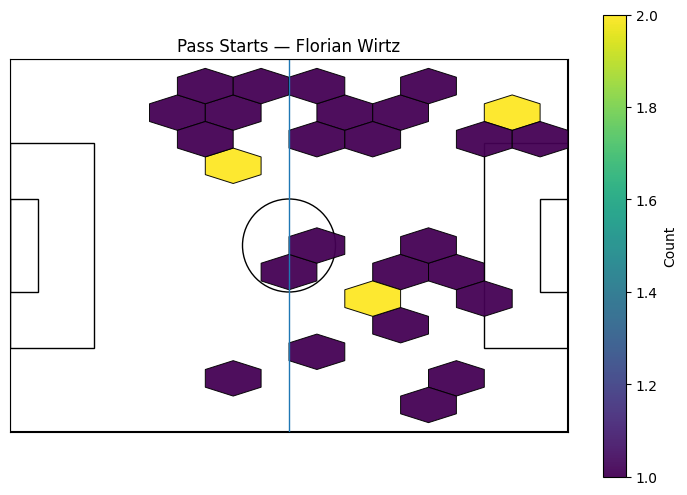

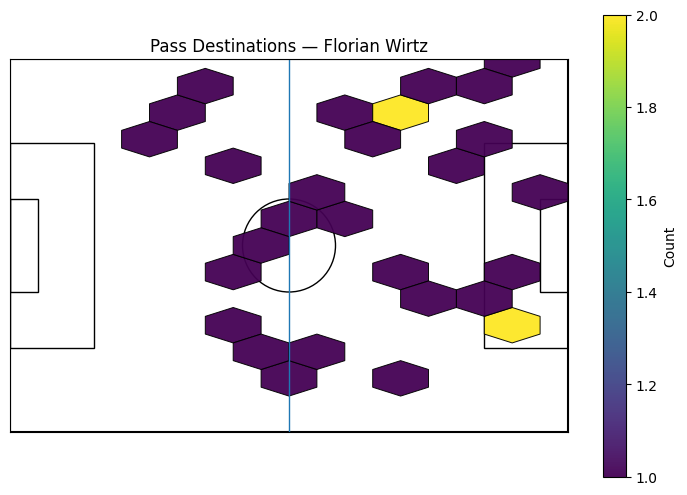

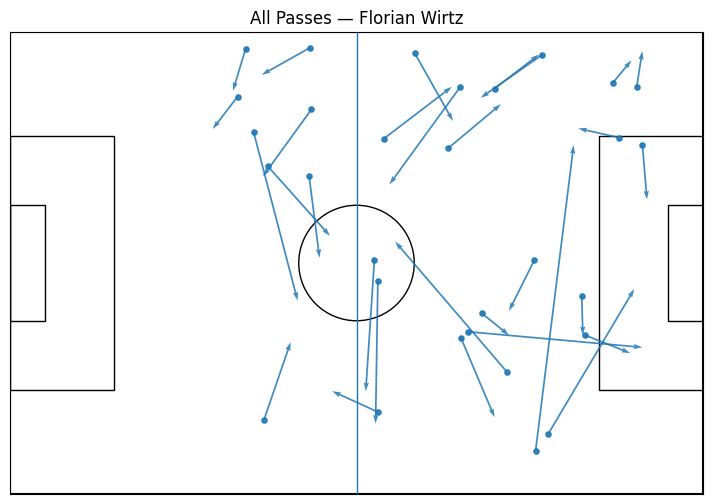

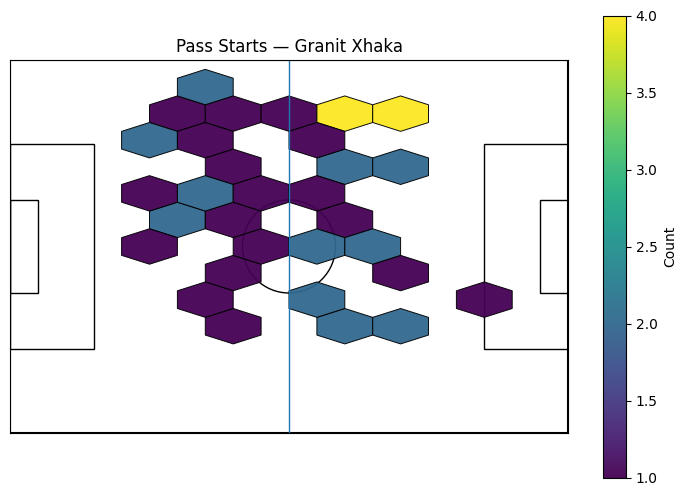

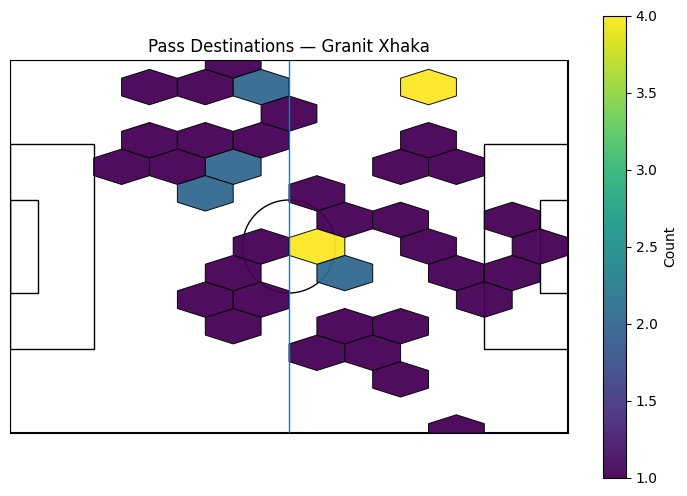

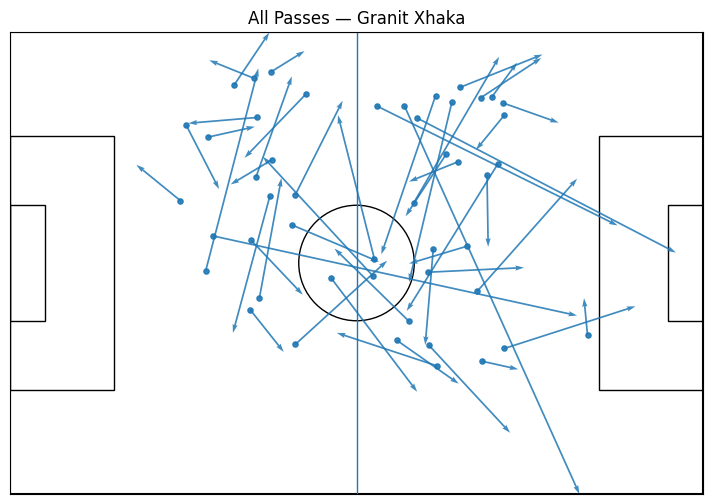

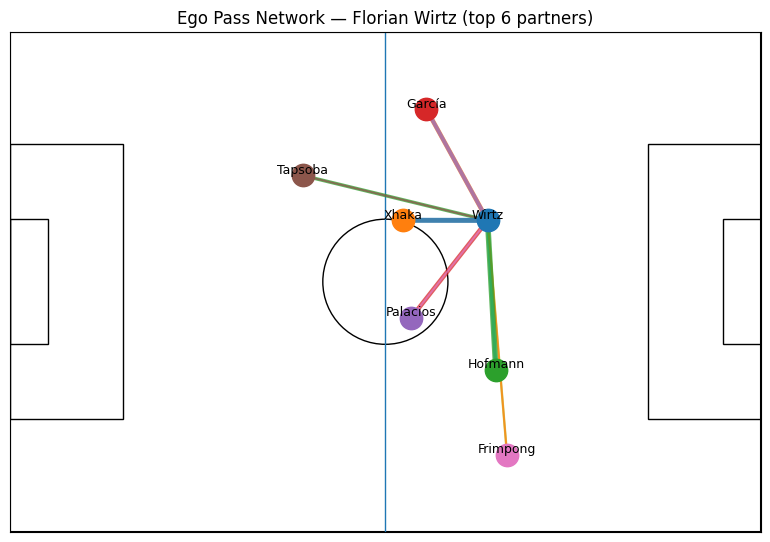

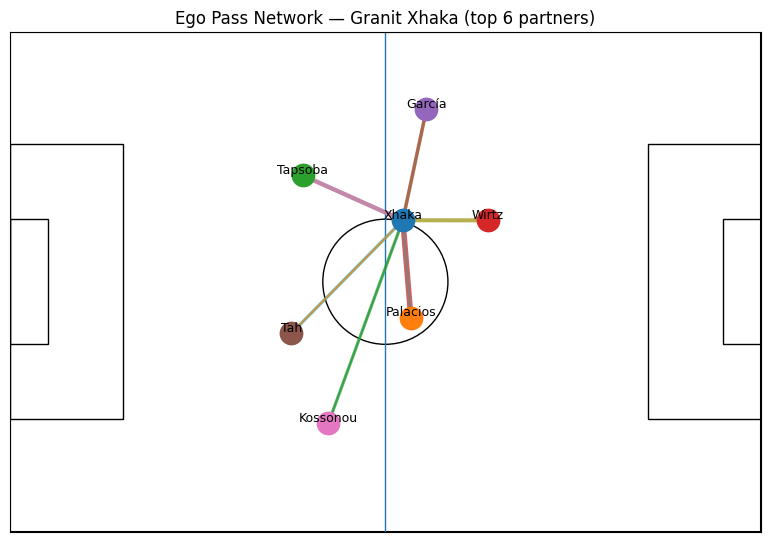

In [41]:
from pathlib import Path

DRIVE_DIR   = Path("/content/drive/MyDrive/leverkusen")
EVENTS_FILE = DRIVE_DIR / "events_3895052.json"
OUT_DIR_MATCH = DRIVE_DIR / "passmaps_out_match"
OUT_DIR_MATCH.mkdir(parents=True, exist_ok=True)

PLAYERS = ["Florian Wirtz", "Granit Xhaka"]
COMPLETED_ONLY = False
FLIP_X = False

print("EVENTS_FILE exists?", EVENTS_FILE.exists(), "|", EVENTS_FILE)

df_match = load_events_df_from_file(EVENTS_FILE)

passes_match = extract_passes(df_match, players=PLAYERS, completed_only=COMPLETED_ONLY)
passes_match = maybe_flip_x(passes_match, flip_x=FLIP_X)

# 1) start/end hexbins + 2) arrow passes
for p in PLAYERS:
    plot_player_start_end_hexbins(
        passes_match, player=p, out_dir=OUT_DIR_MATCH, gridsize=(10, 7), show=True
    )
    plot_player_pass_arrows(
        passes_match, player=p, out_dir=OUT_DIR_MATCH, color="tab:blue", show=True
    )

# 3) ego networks
for p in PLAYERS:
    ego_pass_network(
        df_match, player=p,
        out_path=OUT_DIR_MATCH / f"{p.replace(' ','_').lower()}_ego_network.png",
        top_k=6, show=True
    )



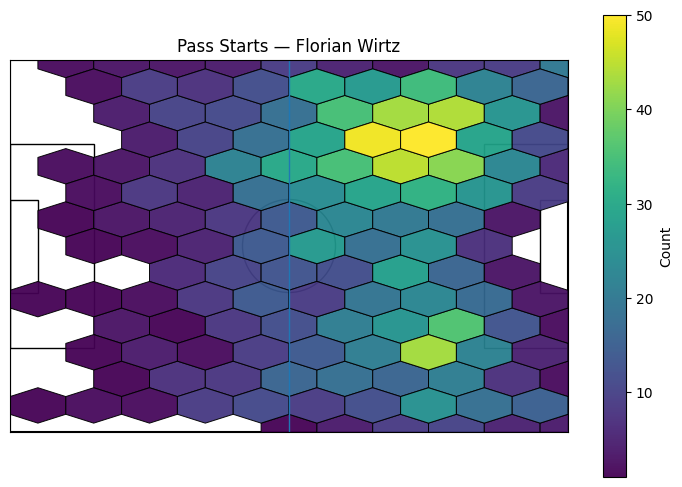

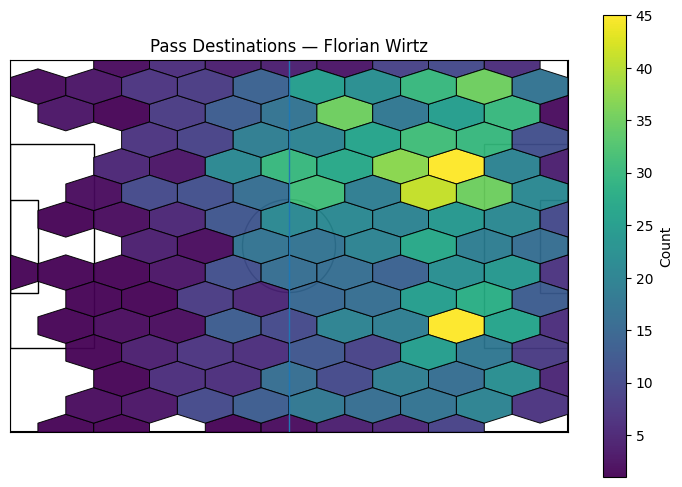

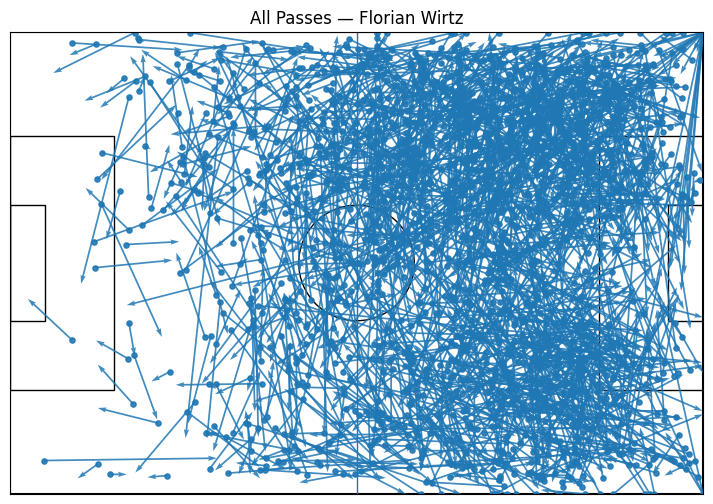

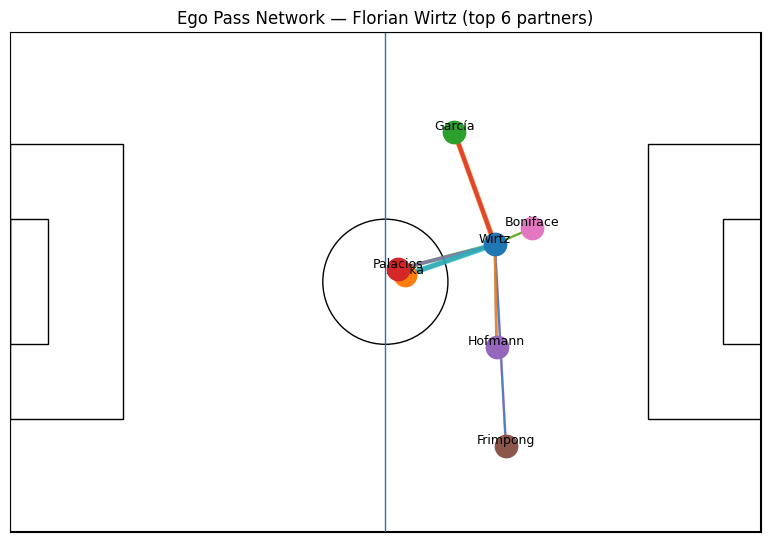

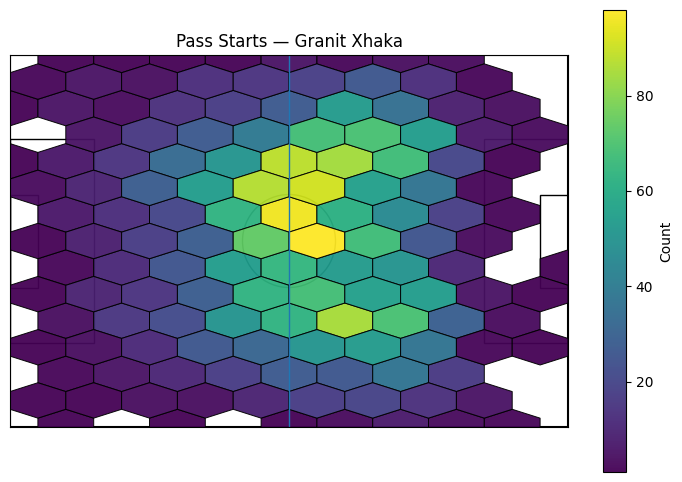

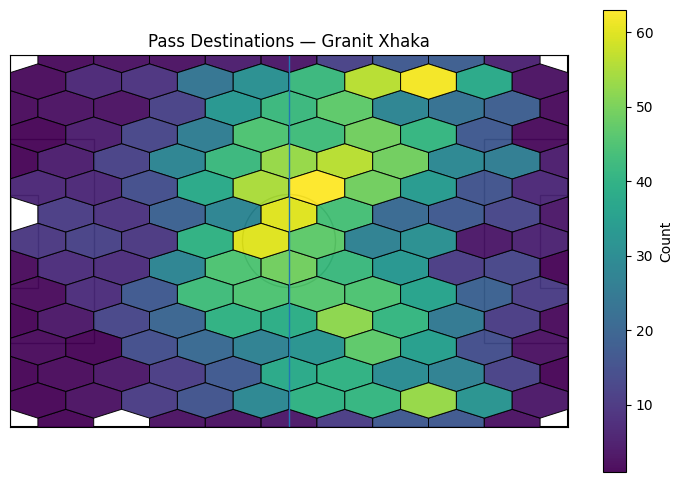

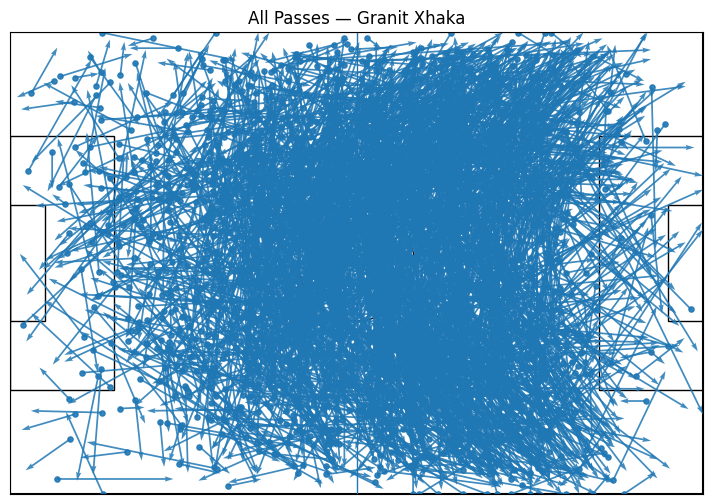

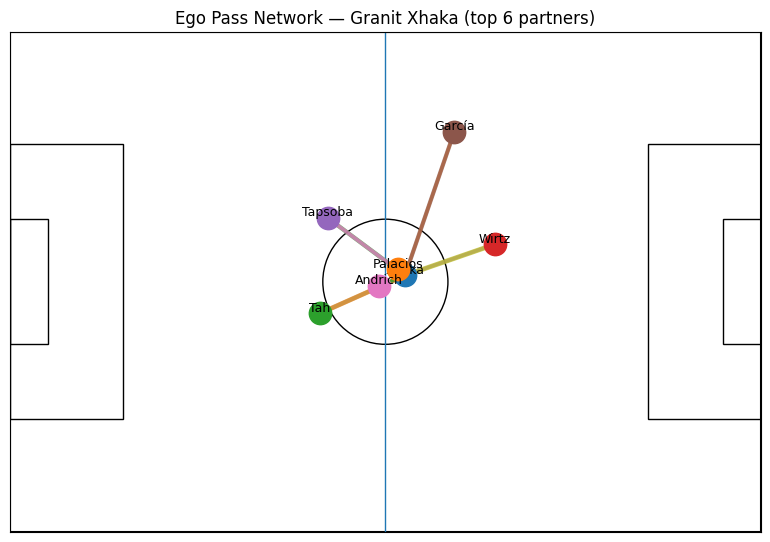

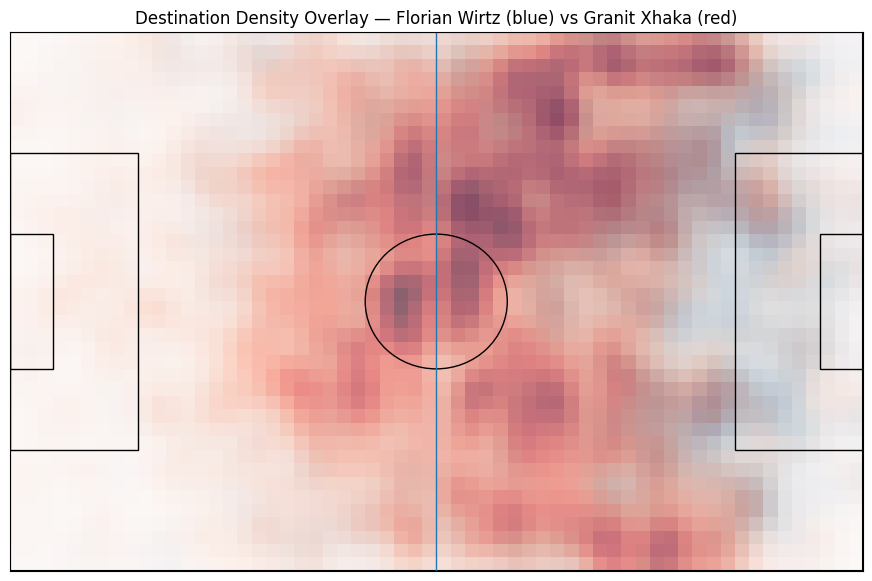

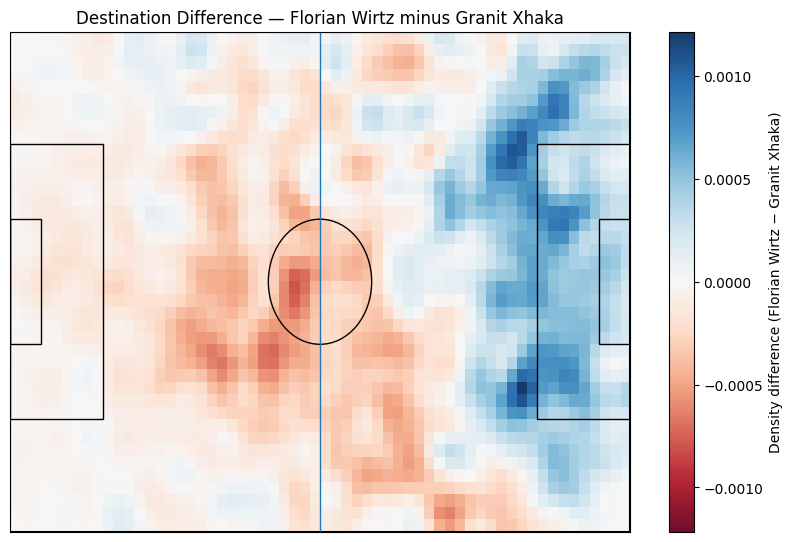

In [42]:
from pathlib import Path

DRIVE_DIR = Path("/content/drive/MyDrive/leverkusen")
OUT_DIR_SEASON = DRIVE_DIR / "passmaps_out_season"
OUT_DIR_SEASON.mkdir(parents=True, exist_ok=True)

PLAYERS = ["Florian Wirtz", "Granit Xhaka"]
COMPLETED_ONLY = False
FLIP_X = False

df_season = load_events_df_from_folder(DRIVE_DIR, pattern="events_*.json")

passes_season = extract_passes(df_season, players=PLAYERS, completed_only=COMPLETED_ONLY)
passes_season = maybe_flip_x(passes_season, flip_x=FLIP_X)

# per-player start/end hexbins + arrows
for p in PLAYERS:
    plot_player_start_end_hexbins(
        passes_season, player=p, out_dir=OUT_DIR_SEASON, gridsize=(10, 7), show=True
    )
    plot_player_pass_arrows(
        passes_season, player=p, out_dir=OUT_DIR_SEASON, color="tab:blue", show=True
    )
    ego_pass_network(
        df_season, player=p,
        out_path=OUT_DIR_SEASON / f"{p.replace(' ','_').lower()}_season_ego_network.png",
        top_k=6, show=True
    )

# overlay + difference (destination density surfaces)
plot_combined_overlay(
    passes_season, PLAYERS[0], PLAYERS[1],
    out_path=OUT_DIR_SEASON / "combined_overlay.png",
    bins_x=60, bins_y=40, smooth_sigma=1.2, show=True
)

plot_difference_heatmap(
    passes_season, PLAYERS[0], PLAYERS[1],
    out_path=OUT_DIR_SEASON / "diff_heatmap.png",
    bins_x=60, bins_y=40, smooth_sigma=1.2, show=True
)

print("Saved season plots to:", OUT_DIR_SEASON)

